### Hybrid Variational Neural Network for Fano fitting (Quantum-Classical Variational Neural Network)

<p>Perform a regression to fit a Fano resonance with Pennylane framework</p>

<p> Let's fit a <a href="https://en.wikipedia.org/wiki/Fano_resonance">Fano resonance</a>, this signal appears on superconducting resonators when photons<sup><a href="https://arxiv.org/abs/2207.03829">[1]</a></sup> interact with spins at low temperatures (from 4K to 10mK in a dilution refrigerator)</p>

This fitting uses a Photonic Quantum Neural network.

#### References:

> https://arxiv.org/abs/2207.03829
>
> https://pennylane.ai/
>
> https://pennylane.ai/qml/demos/quantum_neural_net.html

In [1]:
#pip3 install pennylane pennylane-sf pennylane-lightning

In [2]:
#pip3 install pennylane pennylane-sf pennylane-lightning pennylane-qiskit 

In [3]:
import pennylane as pnl
pnl.__version__

'0.25.0'

In [4]:
import tensorflow as tf
tf.__version__

'2.5.1'

In [5]:
import pennylane as qml
from pennylane import numpy as np
from pennylane.optimize import AdamOptimizer, GradientDescentOptimizer, RMSPropOptimizer
from pennylane import numpy as np
from pennylane.templates.layers import CVNeuralNetLayers
import strawberryfields as sf

import tensorflow as tf
import pandas as pd
import matplotlib.pyplot as plt

from scipy.ndimage import gaussian_filter
from scipy.signal import detrend
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import r2_score

import warnings

warnings.filterwarnings('ignore')

%matplotlib inline

plt.rcParams['figure.figsize'] = [10, 7]
%config InlineBackend.figure_format = 'retina'

In [6]:
fano_data = pd.read_csv("./datasets/signal_080_peak_1_fano_adjust.csv")

In [7]:
def func_fano(x, xc, w, q, y0):
    y = y0+A*(2*(x-xc)/w+q)*(2*(x-xc)/w+q)/(2*(x-xc)/w*2*(x-xc)/w+1)/(1+q*q)
    return y

def scale(arr, lvalue = -np.pi, rvalue = np.pi):
    return np.interp(arr, (arr.min(), arr.max()), (lvalue, rvalue))

def remove_outlier(df_in, col_name, quartiles, rng_arr):
    q1 = df_in[col_name].quantile(quartiles[0])
    q3 = df_in[col_name].quantile(quartiles[1])
    iqr = q3-q1 #Interquartile range
    fence_low  = q1-rng_arr[0]*iqr
    fence_high = q3+rng_arr[1]*iqr
    df_out = df_in.loc[(df_in[col_name] > fence_low) & (df_in[col_name] < fence_high)]
    return df_out

In [8]:
def smooth(data):
    #return data
    #return scipy.ndimage.gaussian_filter(data, sigma=30, mode='reflect', truncate=18.0)
    
    return gaussian_filter(data, sigma=15, mode='reflect', truncate=18.0)
    #return scipy.ndimage.gaussian_filter(data, sigma=15, mode='reflect', truncate=15.0)

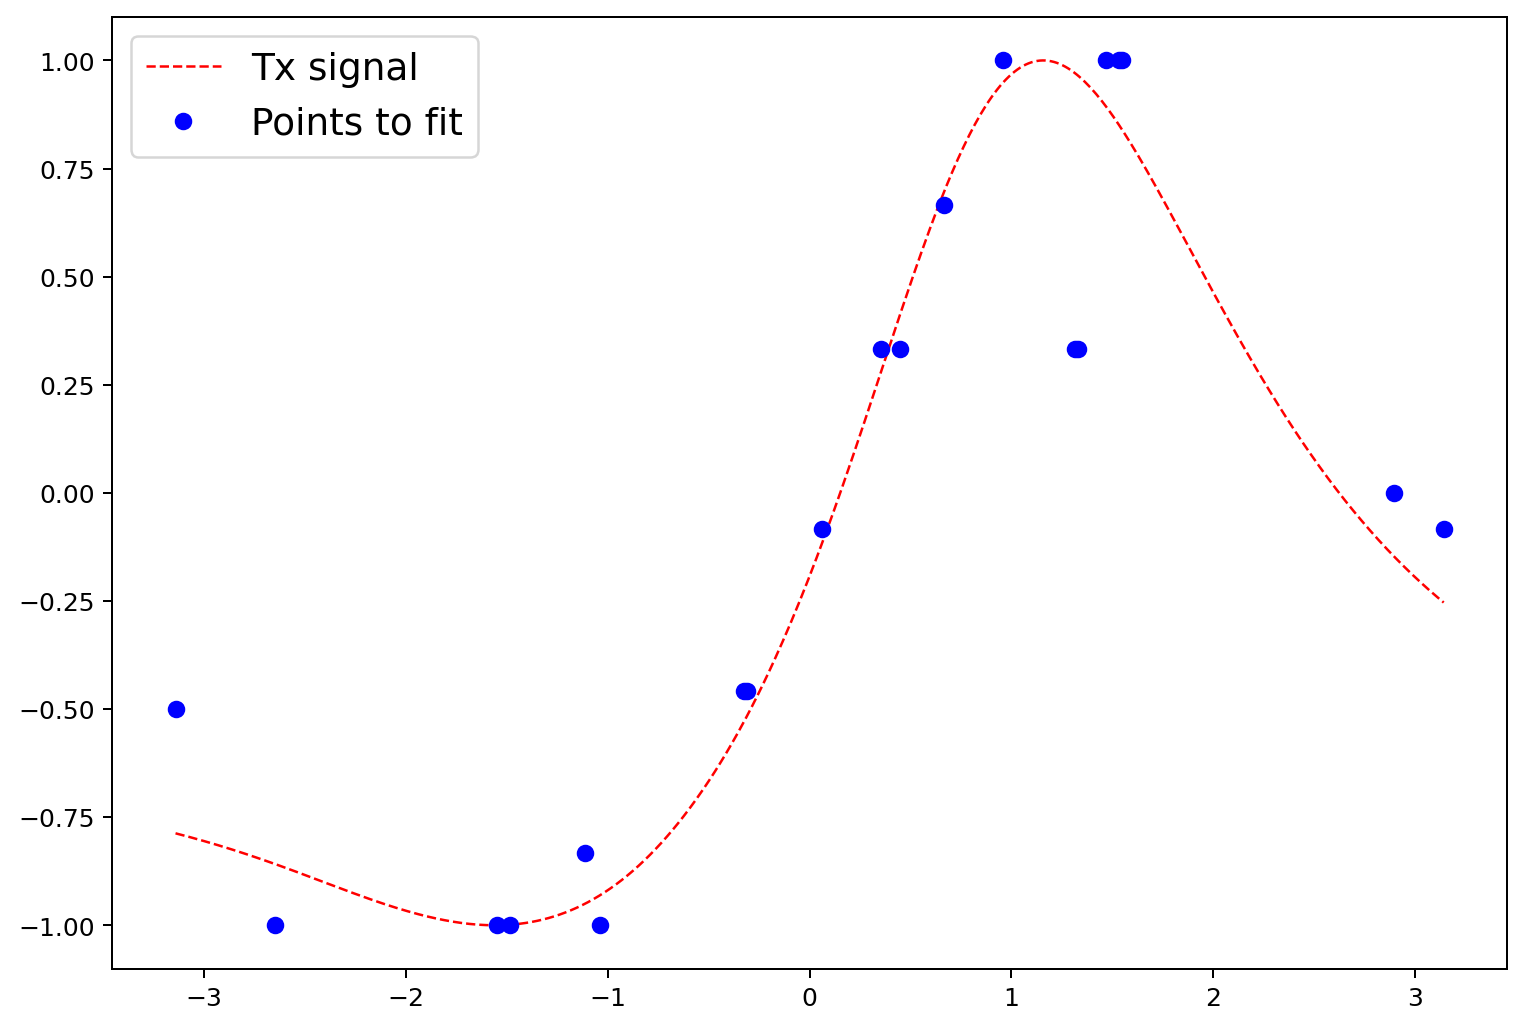

In [9]:
num_samples = 20
eps = 0.2
lb, ub = -1, 1

y0 = fano_data["y0"].values[0]
A = fano_data["A"].values[0]
xc = fano_data["xc"].values[0]
q = fano_data["q"].values[0]
w = fano_data["w"].values[0]

f = lambda x: func_fano(x, xc, w, q, y0)

X_ = fano_data["signal_original_x"].values.reshape(-1,1)

# Create Gaussian distribution (mean = 0, std = 1)
std_scaler = StandardScaler()
std_scaler.fit(X_)
X_ = std_scaler.transform(X_)

#y_ = f(X_)

y_ = fano_data["signal_original_y"].values

# select a better range of data to fit
rng = range(250,700)

X_ = X_.take(rng, axis=0)
y_ = y_.take(rng, axis=0)

# random indices for points selection
#indices = np.array(sorted(np.random.choice(range(X_.shape[0]), num_samples, replace=False)))
#print(indices)

#indices = np.array([19,  40, 156, 159, 173, 175, 191, 207, 213, 253, 358, 359, 448, 543, 559, 613, 651, 657, 737, 754])
indices = [22, 54, 125, 129, 153, 158, 204, 205, 229, 248, 254, 268, 287, 310, 311, 320, 324, 325, 412, 428]

X = X_[indices].reshape(-1,1)
y = y_[indices].reshape(-1,1)

#df = pd.DataFrame(zip(X[:,0].flatten().tolist(), y[:,0].flatten().tolist()), columns = ["X", "y"])
#new_df = remove_outlier(df, "y", [0.25, 0.75], [0.05, 0.05])
#X = new_df["X"].values.reshape(-1,1)
#y = new_df["y"].values.reshape(-1,1)

y = detrend(y)

X = scale(X)
y = scale(y, -1, 1)

X_ = scale(X_)
y_ = scale(y_, -1, 1)

plt.figure(num = "Fano adjust data", figsize = (10, 7), dpi=90, facecolor='w', edgecolor='k')
plt.plot(X_, y_, "r--", label='Tx signal', linewidth = 1)
plt.plot(X, y, "bo", label = 'Points to fit')
plt.legend(loc = 'upper left', fontsize = 15)
plt.show()

In [10]:
#TOKEN = ""

In [11]:
#import xcc

#settings = xcc.Settings(REFRESH_TOKEN=TOKEN)
#settings.save()

In [12]:
num_qubits = 1

In [13]:
dev = qml.device("strawberryfields.fock", wires=num_qubits)
#dev = qml.device('default.gaussian', wires=num_qubits)

#dev = qml.device("strawberryfields.tf", wires=1, cutoff_dim=num_qubits)

#dev = qml.device('strawberryfields.remote', backend="X8", shots=10, sf_token=TOKEN)

In [14]:
def layer(v):
    qml.CVNeuralNetLayers(*v, wires=list(range(num_qubits)))
    #qml.Rotation(v[0], wires=0)
    #qml.Squeezing(v[1], 0.0, wires=0)
    #qml.Rotation(v[0], wires=0)
    # Bias
    #qml.Displacement(v[1], 0.0, wires=0)
    # Element-wise nonlinear transformation
    #qml.Kerr(v[1], wires=0) 

In [15]:
@qml.qnode(dev)
def quantum_neural_net(var, x):
    
    # Encode input x into quantum state
    for i in range(num_qubits):
        #qml.Rotation(x, wires=i)
        qml.Displacement(x, 0.0, wires=i)
    
    #for v in var: 
    layer(var)

    return qml.expval(qml.X(0))

In [16]:
def square_loss(labels, predictions):
    
    loss = 0
    for l, p in zip(labels, predictions):
        loss = loss + (l - p) ** 2

    loss = loss / len(labels)
    
    return loss

In [17]:
def cost(var, features, labels):
    preds = [quantum_neural_net(var, x) for x in features]
    return square_loss(labels, preds)

In [18]:
np.random.seed(0)
shapes = CVNeuralNetLayers.shape(n_layers=3, n_wires=num_qubits)
weights = [np.random.random(shape) for shape in shapes]

#print(weights)

In [19]:
X_data = X.numpy()[:, 0]
y_data = y.numpy()[:, 0]

In [20]:
opt = AdamOptimizer(0.1, beta1=0.9, beta2=0.999)
#opt = GradientDescentOptimizer(stepsize=0.01)
#opt = RMSPropOptimizer(stepsize=0.01,decay=0.9)

cost_plot = []

var = weights
for it in range(500):
    (var, _, _), _cost = opt.step_and_cost(cost, var, X_data, y_data)
    cost_plot.append(_cost)
    print("Iter: {:5d} | Cost: {:0.7f} ".format(it, _cost))

Iter:     0 | Cost: 0.1810859 
Iter:     1 | Cost: 0.1827504 
Iter:     2 | Cost: 0.1371151 
Iter:     3 | Cost: 0.1474881 
Iter:     4 | Cost: 0.1869623 
Iter:     5 | Cost: 0.2117946 
Iter:     6 | Cost: 0.1968799 
Iter:     7 | Cost: 0.1800709 
Iter:     8 | Cost: 0.1765797 
Iter:     9 | Cost: 0.1468871 
Iter:    10 | Cost: 0.1947042 
Iter:    11 | Cost: 0.1423628 
Iter:    12 | Cost: 0.1969157 
Iter:    13 | Cost: 0.1979805 
Iter:    14 | Cost: 0.1446714 
Iter:    15 | Cost: 0.1588546 
Iter:    16 | Cost: 0.2068182 
Iter:    17 | Cost: 0.1408929 
Iter:    18 | Cost: 0.1769758 
Iter:    19 | Cost: 0.2113448 
Iter:    20 | Cost: 0.1419848 
Iter:    21 | Cost: 0.1785420 
Iter:    22 | Cost: 0.1891869 
Iter:    23 | Cost: 0.2338695 
Iter:    24 | Cost: 0.1881692 
Iter:    25 | Cost: 0.2157867 
Iter:    26 | Cost: 0.1410582 
Iter:    27 | Cost: 0.2195874 
Iter:    28 | Cost: 0.1682722 
Iter:    29 | Cost: 0.1679730 
Iter:    30 | Cost: 0.1747531 
Iter:    31 | Cost: 0.1581672 
Iter:   

Iter:   265 | Cost: 0.1786344 
Iter:   266 | Cost: 0.2672955 
Iter:   267 | Cost: 0.1401239 
Iter:   268 | Cost: 0.2103454 
Iter:   269 | Cost: 0.2330343 
Iter:   270 | Cost: 0.1822367 
Iter:   271 | Cost: 0.1667976 
Iter:   272 | Cost: 0.1703465 
Iter:   273 | Cost: 0.1755248 
Iter:   274 | Cost: 0.2200384 
Iter:   275 | Cost: 0.2183592 
Iter:   276 | Cost: 0.1529118 
Iter:   277 | Cost: 0.2346581 
Iter:   278 | Cost: 0.1758820 
Iter:   279 | Cost: 0.1377766 
Iter:   280 | Cost: 0.1364209 
Iter:   281 | Cost: 0.1517725 
Iter:   282 | Cost: 0.1591202 
Iter:   283 | Cost: 0.1916641 
Iter:   284 | Cost: 0.2160081 
Iter:   285 | Cost: 0.1327649 
Iter:   286 | Cost: 0.1984784 
Iter:   287 | Cost: 0.1377768 
Iter:   288 | Cost: 0.1688663 
Iter:   289 | Cost: 0.1869438 
Iter:   290 | Cost: 0.1739275 
Iter:   291 | Cost: 0.1685283 
Iter:   292 | Cost: 0.1695163 
Iter:   293 | Cost: 0.1604577 
Iter:   294 | Cost: 0.2168945 
Iter:   295 | Cost: 0.1617821 
Iter:   296 | Cost: 0.1520462 
Iter:   

In [21]:
for _ in range(2):

    shapes = CVNeuralNetLayers.shape(n_layers=3, n_wires=num_qubits)
    weights = [np.random.random(shape) for shape in shapes]
    var = weights

    for it in range(500):
        var = opt.step(lambda v: cost(v, X_data, y_data), var)
        more_cost = cost(var, X_data, y_data)
        cost_plot.append(more_cost)
        print("Iter: {:5d} | Cost: {:0.7f} ".format(it + 1, more_cost))
        #if cost(var1, X_data, y_data)<0.1:
        #    opt.update_stepsize(0.005)

Iter:     1 | Cost: 0.7778288 
Iter:     2 | Cost: 0.6397046 
Iter:     3 | Cost: 0.7482077 
Iter:     4 | Cost: 0.6409488 
Iter:     5 | Cost: 0.7709108 
Iter:     6 | Cost: 0.8040224 
Iter:     7 | Cost: 0.8413592 
Iter:     8 | Cost: 0.7400208 
Iter:     9 | Cost: 0.7130889 
Iter:    10 | Cost: 0.8396834 
Iter:    11 | Cost: 0.7306540 
Iter:    12 | Cost: 0.6566535 
Iter:    13 | Cost: 0.6421281 
Iter:    14 | Cost: 0.6869511 
Iter:    15 | Cost: 0.7268640 
Iter:    16 | Cost: 0.7457333 
Iter:    17 | Cost: 0.6707201 
Iter:    18 | Cost: 0.7979690 
Iter:    19 | Cost: 0.7621930 
Iter:    20 | Cost: 0.8025939 
Iter:    21 | Cost: 0.7871253 
Iter:    22 | Cost: 0.7443205 
Iter:    23 | Cost: 0.8595729 
Iter:    24 | Cost: 0.7358980 
Iter:    25 | Cost: 0.6774552 
Iter:    26 | Cost: 0.7465646 
Iter:    27 | Cost: 0.8438652 
Iter:    28 | Cost: 0.6849040 
Iter:    29 | Cost: 0.8588793 
Iter:    30 | Cost: 0.6644360 
Iter:    31 | Cost: 0.8666260 
Iter:    32 | Cost: 0.7320697 
Iter:   

Iter:   267 | Cost: 0.5454212 
Iter:   268 | Cost: 0.8022014 
Iter:   269 | Cost: 0.9300566 
Iter:   270 | Cost: 0.6313289 
Iter:   271 | Cost: 0.8320247 
Iter:   272 | Cost: 0.7058213 
Iter:   273 | Cost: 0.8565274 
Iter:   274 | Cost: 0.6065345 
Iter:   275 | Cost: 0.8937761 
Iter:   276 | Cost: 0.6269928 
Iter:   277 | Cost: 0.7713189 
Iter:   278 | Cost: 0.6038642 
Iter:   279 | Cost: 0.8354865 
Iter:   280 | Cost: 0.7172622 
Iter:   281 | Cost: 0.8105028 
Iter:   282 | Cost: 0.8295149 
Iter:   283 | Cost: 0.7113289 
Iter:   284 | Cost: 0.7142716 
Iter:   285 | Cost: 0.7525571 
Iter:   286 | Cost: 0.8056917 
Iter:   287 | Cost: 0.7538758 
Iter:   288 | Cost: 0.7056261 
Iter:   289 | Cost: 0.8172126 
Iter:   290 | Cost: 0.7652468 
Iter:   291 | Cost: 0.8305326 
Iter:   292 | Cost: 0.8423052 
Iter:   293 | Cost: 0.7226311 
Iter:   294 | Cost: 0.6530399 
Iter:   295 | Cost: 0.7827071 
Iter:   296 | Cost: 0.8830141 
Iter:   297 | Cost: 0.8497275 
Iter:   298 | Cost: 0.7396380 
Iter:   

Iter:    33 | Cost: 0.2413032 
Iter:    34 | Cost: 0.2212212 
Iter:    35 | Cost: 0.2228800 
Iter:    36 | Cost: 0.2237776 
Iter:    37 | Cost: 0.2059433 
Iter:    38 | Cost: 0.1730815 
Iter:    39 | Cost: 0.1567984 
Iter:    40 | Cost: 0.1762819 
Iter:    41 | Cost: 0.2053666 
Iter:    42 | Cost: 0.2614419 
Iter:    43 | Cost: 0.2771464 
Iter:    44 | Cost: 0.1904094 
Iter:    45 | Cost: 0.1845850 
Iter:    46 | Cost: 0.1858087 
Iter:    47 | Cost: 0.2232295 
Iter:    48 | Cost: 0.2220778 
Iter:    49 | Cost: 0.1693472 
Iter:    50 | Cost: 0.2590699 
Iter:    51 | Cost: 0.1683153 
Iter:    52 | Cost: 0.2745689 
Iter:    53 | Cost: 0.1915831 
Iter:    54 | Cost: 0.2257346 
Iter:    55 | Cost: 0.1743766 
Iter:    56 | Cost: 0.2020462 
Iter:    57 | Cost: 0.1710082 
Iter:    58 | Cost: 0.1469825 
Iter:    59 | Cost: 0.2007117 
Iter:    60 | Cost: 0.1934837 
Iter:    61 | Cost: 0.1833100 
Iter:    62 | Cost: 0.1381336 
Iter:    63 | Cost: 0.3494074 
Iter:    64 | Cost: 0.2176050 
Iter:   

Iter:   299 | Cost: 0.2994333 
Iter:   300 | Cost: 0.2905176 
Iter:   301 | Cost: 0.2725493 
Iter:   302 | Cost: 0.3597844 
Iter:   303 | Cost: 0.1876196 
Iter:   304 | Cost: 0.1226108 
Iter:   305 | Cost: 0.2121806 
Iter:   306 | Cost: 0.1736321 
Iter:   307 | Cost: 0.1513951 
Iter:   308 | Cost: 0.2069185 
Iter:   309 | Cost: 0.2408808 
Iter:   310 | Cost: 0.1847811 
Iter:   311 | Cost: 0.1783159 
Iter:   312 | Cost: 0.1890541 
Iter:   313 | Cost: 0.2863358 
Iter:   314 | Cost: 0.1887329 
Iter:   315 | Cost: 0.2483043 
Iter:   316 | Cost: 0.1699424 
Iter:   317 | Cost: 0.2066369 
Iter:   318 | Cost: 0.2231714 
Iter:   319 | Cost: 0.2097083 
Iter:   320 | Cost: 0.2205385 
Iter:   321 | Cost: 0.1902467 
Iter:   322 | Cost: 0.1663149 
Iter:   323 | Cost: 0.2517820 
Iter:   324 | Cost: 0.2308142 
Iter:   325 | Cost: 0.2525266 
Iter:   326 | Cost: 0.2341772 
Iter:   327 | Cost: 0.1617658 
Iter:   328 | Cost: 0.1758939 
Iter:   329 | Cost: 0.2398321 
Iter:   330 | Cost: 0.1921073 
Iter:   

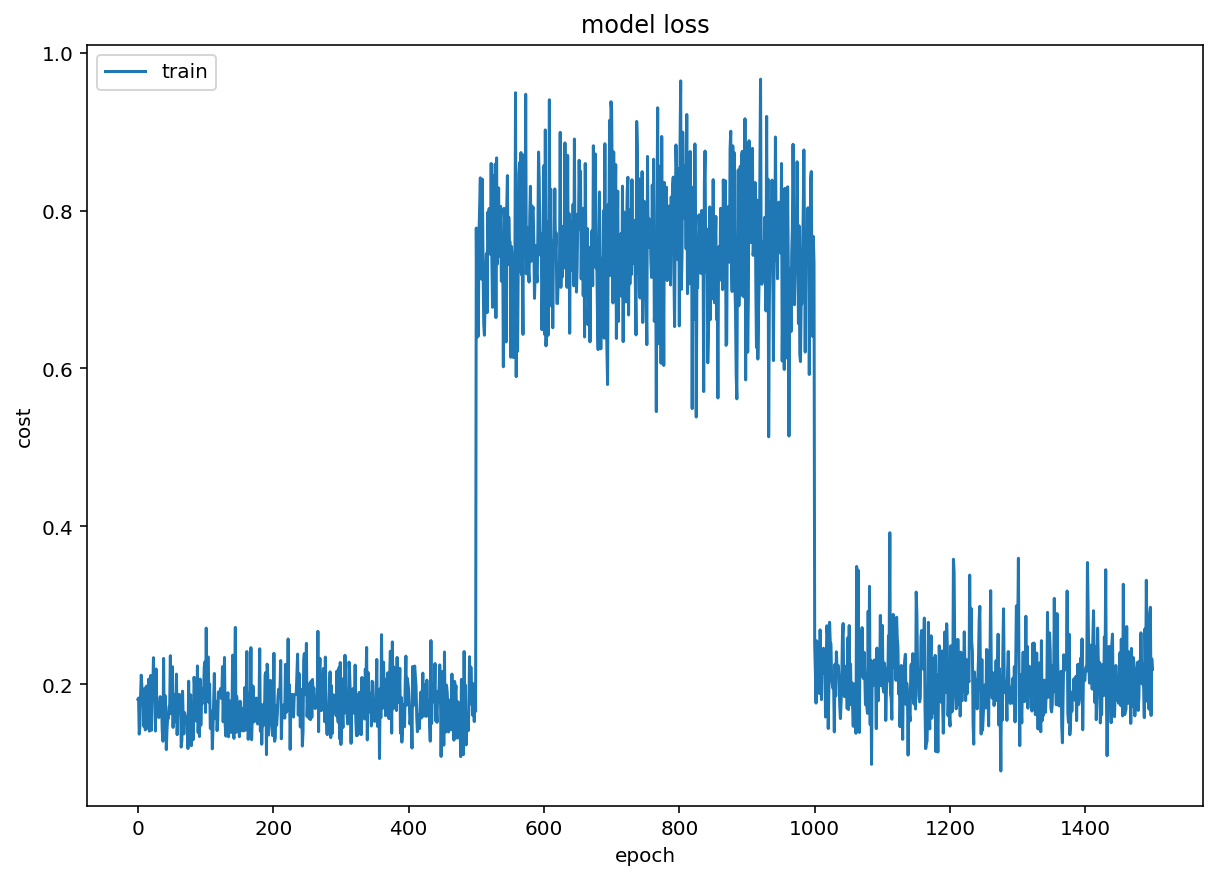

In [22]:
# summarize history for loss
plt.plot(cost_plot)
plt.title('model loss')
plt.ylabel('cost')
plt.xlabel('epoch')
plt.legend(['train'], loc='upper left')
plt.show()

In [23]:
X_pred = X_.numpy()[:,0]

In [24]:
y_predict = [quantum_neural_net(var, x_) for x_ in X_pred]

In [25]:
y_predict_smooth = smooth(y_predict)

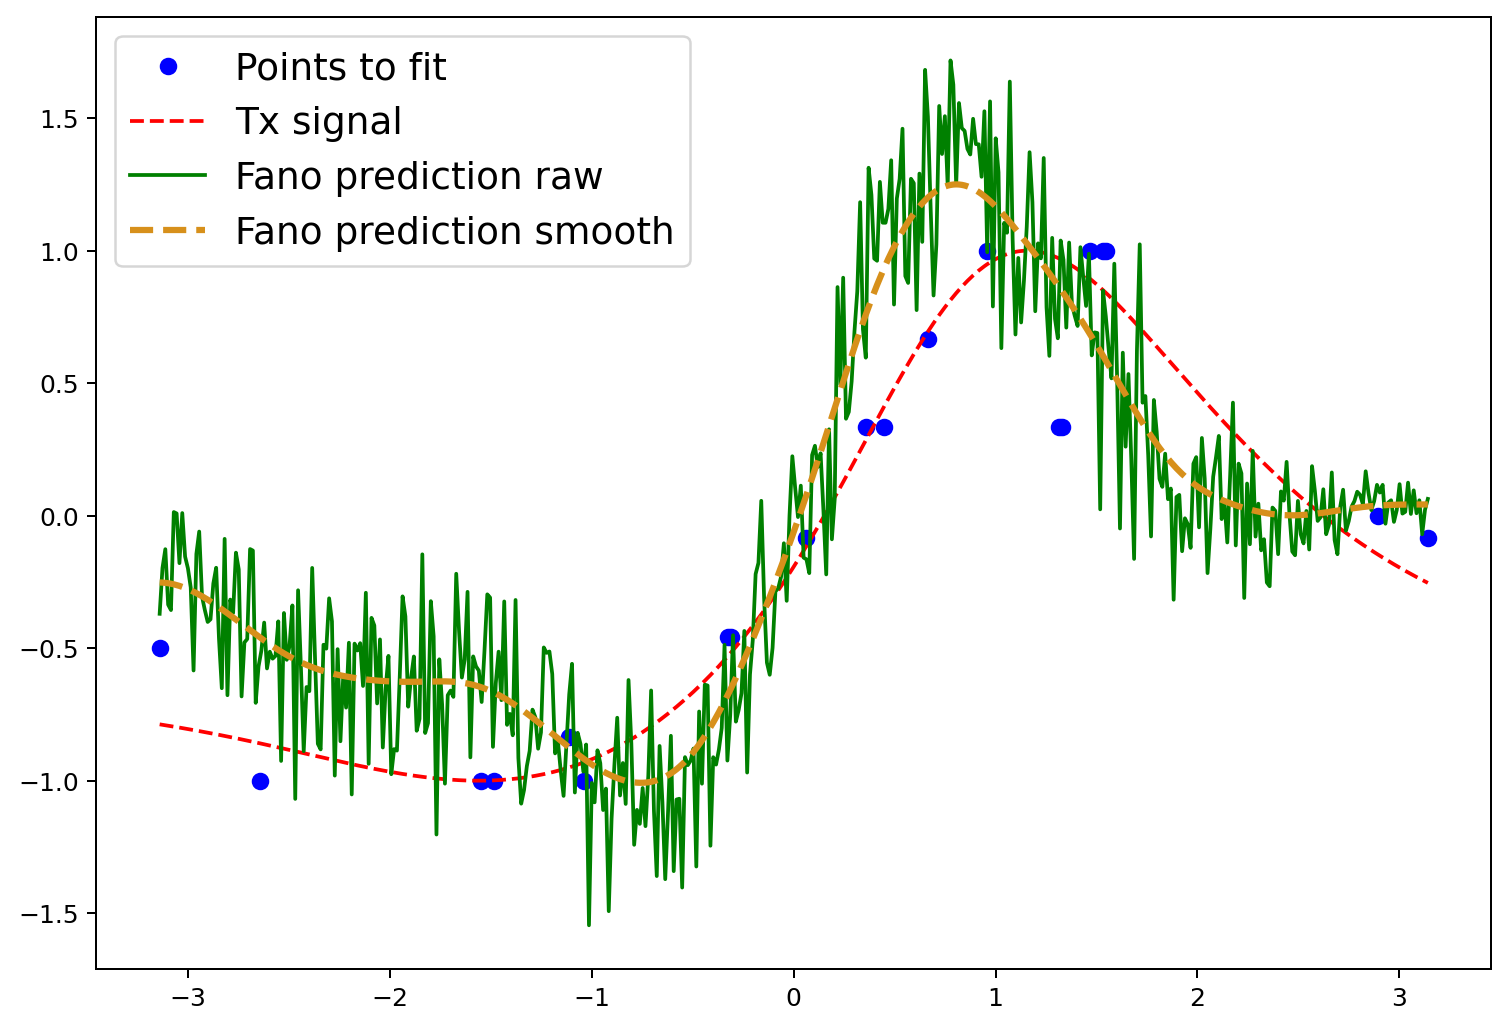

In [26]:
plt.figure(num = "Fano adjust QML 1", figsize = (10, 7), dpi=90, facecolor='w', edgecolor='k')

# plot data
plt.plot(X, y, "bo", label = 'Points to fit')

# plot target function
plt.plot(X_, y_, "r--", label = 'Tx signal')

# plot prediction
plt.plot(X_, y_predict, "g-", label = 'Fano prediction raw')
plt.plot(X_, y_predict_smooth, "--", color='#d7901b', linewidth=2.5, label = 'Fano prediction smooth')
plt.legend(loc = 'upper left', fontsize = 15)
plt.show()

In [27]:
print("Score: %.10f" % r2_score(y_, y_predict))   

Score: 0.6770587842


In [28]:
import qiskit.tools.jupyter

%qiskit_version_table
%qiskit_copyright